**GOAL**:
- Extract features from both USE and MobiletNet
- Concatenate results
- Build a simple sequential neural network with the concatenated embeddings
as inputs and the desired class as outputs.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import project_tools as pt
import data_science_functions as ds
# import string
# import nltk
# import gensim
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
import os
from glob import glob

from plot_keras_history import show_history, plot_history

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

# Feature extraction from USE

In [2]:
# Load the data
df = (
    pd.read_csv('text_data.csv.gz', index_col='product_id')
    .drop('name', axis=1)
)

# Load rare_tokens to be filtered and cast to a list
rare_tokens = pd.read_csv('rare_tokens.csv.gz')
rare_tokens = rare_tokens.words.tolist()

# Generate the tokens of each description
df['tokens'] = df.description.apply(
    lambda x: pt.tokenize_description_v2(
        x,
        rare_tokens,
        filter_numeric=True,
    )
)

In [3]:
df.head(2)

,description,category,tokens
product_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,"Elegance Polyester Multicolor Abstract Eyelet Door Curtain. Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",home_furnishing,"[elegance, polyester, multicolor, abstract, eyelet, door, curtain, key, elegance, polyester, multicolor, abstract, eyelet, door, curtain, floral, curtain, elegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, curtain, enhances, look, interior, curtain, made, high, quality, polyester, fabric, eyelet, style, metal, ring, make, room, environment, curtain, wrinkle, anti, elegant, give, home, bright, appeal, design, attention, sure, heart, contemporary, eyelet, curtain, smoothly, draw, apart, first, thing, morning, bright, sun, ray, want, wish, good, morning, whole, world, draw, evening, create, special, moment, beauty, soothing, print, bring, home, elegant, curtain, light, room, get, right, amount, elegance, polyester, multicolor, abstract, eyelet, door, curtain, cm, height, general, ...]"
7b72c92c2f6c40268628ec5f14c6d590,"Sathiyas Cotton Bath Towel. Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",baby_care,"[sathiyas, cotton, bath, towel, sathiyas, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, machine, washable, yes, material, cotton, design, self, design, general, brand, sathiyas, type, bath, towel, gsm, model, name, sathiyas, cotton, bath, towel, ideal, men, woman, boy, girl, model, id, red, yellow, blue, size, dimension, length, inch, width, inch, box, number, content, sale, package, sale, package, bath, towel]"


In [98]:
df['category'] = df.category.str.replace('&', 'and')
df.category.unique()

array(['home_furnishing', 'baby_care', 'watches',
       'home_decor_and_festive_needs', 'kitchen_and_dining',
       'beauty_and_personal_care', 'computers'], dtype=object)

In [5]:
# recompose text from tokens
corpus = df.tokens.str.join(' ')

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)


def embed(input):
  return model(input)


USE_embeddings = embed(corpus)
USE_embeddings.shape

2023-06-20 15:40:15.741577: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


2023-06-20 15:40:22.552959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


TensorShape([1050, 512])

In [6]:
USE_embeddings_df = pd.DataFrame(
    USE_embeddings,
    index=df.index,
    columns=[f'USE_component_{k}' for k in range(USE_embeddings.shape[1])]
)

In [7]:
USE_embeddings_df.head()

,USE_component_0,USE_component_1,USE_component_2,USE_component_3,USE_component_4,USE_component_5,USE_component_6,USE_component_7,USE_component_8,USE_component_9,USE_component_10,USE_component_11,USE_component_12,USE_component_13,USE_component_14,USE_component_15,USE_component_16,USE_component_17,USE_component_18,USE_component_19,USE_component_20,USE_component_21,USE_component_22,USE_component_23,USE_component_24,...,USE_component_487,USE_component_488,USE_component_489,USE_component_490,USE_component_491,USE_component_492,USE_component_493,USE_component_494,USE_component_495,USE_component_496,USE_component_497,USE_component_498,USE_component_499,USE_component_500,USE_component_501,USE_component_502,USE_component_503,USE_component_504,USE_component_505,USE_component_506,USE_component_507,USE_component_508,USE_component_509,USE_component_510,USE_component_511
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,-0.053519,-0.053060,0.045070,0.048323,0.030883,0.053657,-0.028116,0.036761,-0.010066,-0.034005,-0.053910,0.021450,0.050619,-0.054487,0.027007,0.052937,0.054331,0.031658,0.054485,0.030019,-0.028924,-0.047503,-0.017206,-0.052397,-0.053081,...,-0.030279,-0.045738,0.006209,-0.029917,-0.003547,-0.034191,-0.053675,-0.010827,0.054492,0.053929,0.053175,-0.054431,0.044200,0.037451,0.054495,-0.048612,-0.054483,-0.054035,0.052842,0.034995,-0.053535,0.043256,0.048271,0.045517,-0.043024
7b72c92c2f6c40268628ec5f14c6d590,-0.041722,-0.039984,-0.000224,0.039430,0.051913,0.057649,0.051701,-0.029872,-0.023727,-0.045448,-0.045579,0.045372,-0.055915,-0.055141,0.057439,-0.053735,0.054706,-0.052408,0.028259,0.055436,-0.011747,0.048792,0.053108,-0.057401,0.040922,...,-0.039410,-0.023705,0.034793,0.025965,-0.042635,0.050545,-0.045741,-0.054322,0.057650,-0.033396,0.003192,-0.057343,0.008936,0.057554,0.057649,0.044541,-0.057512,-0.054354,-0.049278,-0.027530,-0.051291,-0.010424,0.025962,0.045426,0.019441
64d5d4a258243731dc7bbb1eef49ad74,-0.053734,-0.038837,-0.026743,0.053200,0.051601,0.053696,0.051084,0.034754,-0.040591,0.044201,-0.053052,0.051347,-0.025340,-0.053814,0.053803,-0.027565,0.053426,-0.017127,0.038945,0.052175,0.018100,0.053459,0.050957,-0.053671,0.052824,...,-0.032372,-0.024007,0.052840,0.050790,0.039559,0.052916,0.047236,-0.053779,0.053818,0.033410,-0.013591,-0.053805,0.017765,0.050401,0.053819,0.050409,-0.053819,-0.053407,0.004893,0.042462,-0.052525,0.046325,0.046371,-0.006871,-0.047135
d4684dcdc759dd9cdf41504698d737d8,-0.053897,-0.052809,0.053431,0.052487,0.053878,0.042467,0.008064,0.011719,0.023310,-0.050288,-0.048477,0.053397,0.037518,-0.053807,0.053261,0.053479,0.053690,0.053035,-0.031622,0.053451,-0.045270,0.048446,0.053711,-0.053278,0.049893,...,0.009514,-0.053811,-0.053562,0.052804,0.053730,-0.029780,-0.045985,-0.052121,0.053895,0.032886,0.013098,-0.050861,-0.047804,-0.023283,0.053902,-0.019811,-0.053902,0.023056,0.053237,-0.051261,-0.052120,0.053216,0.052879,-0.031654,-0.048502
6325b6870c54cd47be6ebfbffa620ec7,-0.051443,-0.045506,0.050313,0.046602,0.051441,0.049044,-0.034499,0.042526,0.002839,-0.038795,-0.050718,0.051407,-0.029743,-0.051453,0.051418,0.051402,0.051387,0.049478,-0.012119,0.050859,-0.049757,0.044415,0.051265,-0.051445,0.051353,...,-0.050732,-0.051201,-0.051437,0.044523,0.051187,-0.041512,-0.021192,-0.051432,0.051432,0.017262,-0.043049,-0.047954,-0.046423,-0.051424,0.051453,-0.044610,-0.051453,-0.047874,0.049121,-0.051367,-0.051072,0.051433,0.051428,-0.033920,-0.026644


# Feature extraction from Mobilenet

In [14]:
mobile = tf.keras.applications.mobilenet.MobileNet()
model = tf.keras.models.Model(inputs=mobile.inputs, outputs=mobile.layers[-2].output)

images_features = []
image_dir = './data/Flipkart/Images/'



for product_id in tqdm(df.index):
    image = tf.keras.utils.load_img(
        os.path.join(image_dir, f'{product_id}.jpg'),
        target_size=(224, 224)
    )
    input_arr = tf.keras.utils.img_to_array(image) 
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = tf.keras.applications.mobilenet.preprocess_input(input_arr)
    images_features.append(model.predict(input_arr, verbose=0)[0])

images_features = np.asarray(images_features)
images_features.shape

 64%|██████▍   | 677/1050 [01:22<00:44,  8.42it/s]/home/louberehc/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [02:18<00:00,  7.56it/s]


(1050, 1000)

In [17]:
image_features_df = pd.DataFrame(
    images_features,
    index=df.index,
    columns=[f'MobileNet_component_{k}' for k in range(images_features.shape[1])]
)

image_features_df.head()

,MobileNet_component_0,MobileNet_component_1,MobileNet_component_2,MobileNet_component_3,MobileNet_component_4,MobileNet_component_5,MobileNet_component_6,MobileNet_component_7,MobileNet_component_8,MobileNet_component_9,MobileNet_component_10,MobileNet_component_11,MobileNet_component_12,MobileNet_component_13,MobileNet_component_14,MobileNet_component_15,MobileNet_component_16,MobileNet_component_17,MobileNet_component_18,MobileNet_component_19,MobileNet_component_20,MobileNet_component_21,MobileNet_component_22,MobileNet_component_23,MobileNet_component_24,...,MobileNet_component_975,MobileNet_component_976,MobileNet_component_977,MobileNet_component_978,MobileNet_component_979,MobileNet_component_980,MobileNet_component_981,MobileNet_component_982,MobileNet_component_983,MobileNet_component_984,MobileNet_component_985,MobileNet_component_986,MobileNet_component_987,MobileNet_component_988,MobileNet_component_989,MobileNet_component_990,MobileNet_component_991,MobileNet_component_992,MobileNet_component_993,MobileNet_component_994,MobileNet_component_995,MobileNet_component_996,MobileNet_component_997,MobileNet_component_998,MobileNet_component_999
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,-6.907565,-3.640539,-5.543317,-5.131344,-6.398283,-4.566835,-5.429980,-0.298964,1.306576,2.261568,-1.276243,3.261032,3.687768,0.214665,2.995415,-0.204328,1.201007,3.182588,2.686737,2.740953,-1.678531,-3.656979,-0.349429,-0.870284,0.837836,...,1.390593,-4.088804,-3.146842,-3.296602,-5.180143,-4.505603,-1.911558,5.871465,-3.341691,-2.410921,-1.099695,-2.589015,-1.612894,-1.785321,-2.811373,-1.844408,-2.791584,-2.157384,-4.744727,-3.221828,1.156588,0.092389,-3.861678,-0.350559,1.502788
7b72c92c2f6c40268628ec5f14c6d590,-0.761519,-1.559877,-2.802782,-0.984374,-4.146284,-0.713606,-5.368144,-1.108315,-4.219600,-2.105635,-1.816751,-1.312072,-3.503740,-5.436931,-1.679037,-0.593286,-2.636722,0.158218,-0.484680,-1.999258,-0.089881,-3.888876,-3.198055,-8.115603,-5.037665,...,-0.252977,-0.021312,2.940917,-1.789930,1.269929,-1.359392,-1.466644,1.789824,0.598472,1.948509,2.202276,-2.234828,6.275623,1.940398,-0.806741,2.774101,-0.368720,-3.407609,-2.695821,4.291363,0.447360,1.345807,-0.026736,6.981294,4.500747
64d5d4a258243731dc7bbb1eef49ad74,-1.625205,-2.635780,-4.608310,-8.318931,-5.668677,-2.030307,-2.953663,-2.825427,-3.927833,-0.758825,-3.745661,-4.492832,-2.584330,-4.844900,-1.879967,-1.856250,-3.436444,-0.198376,-2.633416,-2.999208,-5.303754,-4.542162,-5.122362,-6.364506,-1.364802,...,0.009542,0.812106,-0.170014,-0.909368,0.900205,-0.881590,2.629074,-1.463674,-2.899367,0.603255,-2.378213,-4.614649,2.754510,-3.346609,-6.148611,-0.768685,-1.133987,-2.218430,-3.710472,-2.615560,-1.881004,-0.776110,-3.168130,0.581062,2.156751
d4684dcdc759dd9cdf41504698d737d8,0.194298,-1.913051,1.124771,-0.390231,0.143823,1.128698,-1.978329,-1.428998,0.900681,-1.918233,-4.981120,-2.959623,-1.809269,-6.320896,-0.882317,1.418569,0.347472,-0.485900,-1.046891,-2.921104,-2.049241,-6.214575,-3.948079,-2.156913,-5.153284,...,-1.070523,-2.044341,1.155191,-0.476298,0.118387,-3.448961,-5.078454,1.013085,-2.492167,-1.779197,-0.049456,-6.218974,-0.807226,-0.377749,-2.023737,0.838300,-6.059501,-1.711978,-6.324614,-4.020989,-4.875948,-4.311462,-3.869863,-2.295837,0.994919
6325b6870c54cd47be6ebfbffa620ec7,-4.726907,1.968036,-0.784631,-7.279674,-3.792159,-1.159216,-0.207282,-0.416850,1.057173,-3.886367,-4.038130,-1.566030,-0.989846,-4.483693,-2.708739,1.970171,1.884152,-1.368842,-1.806566,-0.001078,-2.638564,-3.541979,-4.296129,-5.618736,-1.698770,...,-0.241327,-3.170983,-3.039026,-1.739883,-2.370612,-0.303649,-2.346244,4.582392,-2.788088,3.449340,2.457116,-4.624627,1.147768,3.485906,3.551515,0.846654,-2.586937,-1.667675,-3.188300,-0.039011,0.788001,-2.095606,-5.875643,1.002233,1.158788


# Concatenate

In [99]:
features = image_features_df.merge(
    USE_embeddings_df,
    how='inner',
    on='product_id'
)

In [100]:
features.head()

,MobileNet_component_0,MobileNet_component_1,MobileNet_component_2,MobileNet_component_3,MobileNet_component_4,MobileNet_component_5,MobileNet_component_6,MobileNet_component_7,MobileNet_component_8,MobileNet_component_9,MobileNet_component_10,MobileNet_component_11,MobileNet_component_12,MobileNet_component_13,MobileNet_component_14,MobileNet_component_15,MobileNet_component_16,MobileNet_component_17,MobileNet_component_18,MobileNet_component_19,MobileNet_component_20,MobileNet_component_21,MobileNet_component_22,MobileNet_component_23,MobileNet_component_24,...,USE_component_487,USE_component_488,USE_component_489,USE_component_490,USE_component_491,USE_component_492,USE_component_493,USE_component_494,USE_component_495,USE_component_496,USE_component_497,USE_component_498,USE_component_499,USE_component_500,USE_component_501,USE_component_502,USE_component_503,USE_component_504,USE_component_505,USE_component_506,USE_component_507,USE_component_508,USE_component_509,USE_component_510,USE_component_511
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,-6.907565,-3.640539,-5.543317,-5.131344,-6.398283,-4.566835,-5.429980,-0.298964,1.306576,2.261568,-1.276243,3.261032,3.687768,0.214665,2.995415,-0.204328,1.201007,3.182588,2.686737,2.740953,-1.678531,-3.656979,-0.349429,-0.870284,0.837836,...,-0.030279,-0.045738,0.006209,-0.029917,-0.003547,-0.034191,-0.053675,-0.010827,0.054492,0.053929,0.053175,-0.054431,0.044200,0.037451,0.054495,-0.048612,-0.054483,-0.054035,0.052842,0.034995,-0.053535,0.043256,0.048271,0.045517,-0.043024
7b72c92c2f6c40268628ec5f14c6d590,-0.761519,-1.559877,-2.802782,-0.984374,-4.146284,-0.713606,-5.368144,-1.108315,-4.219600,-2.105635,-1.816751,-1.312072,-3.503740,-5.436931,-1.679037,-0.593286,-2.636722,0.158218,-0.484680,-1.999258,-0.089881,-3.888876,-3.198055,-8.115603,-5.037665,...,-0.039410,-0.023705,0.034793,0.025965,-0.042635,0.050545,-0.045741,-0.054322,0.057650,-0.033396,0.003192,-0.057343,0.008936,0.057554,0.057649,0.044541,-0.057512,-0.054354,-0.049278,-0.027530,-0.051291,-0.010424,0.025962,0.045426,0.019441
64d5d4a258243731dc7bbb1eef49ad74,-1.625205,-2.635780,-4.608310,-8.318931,-5.668677,-2.030307,-2.953663,-2.825427,-3.927833,-0.758825,-3.745661,-4.492832,-2.584330,-4.844900,-1.879967,-1.856250,-3.436444,-0.198376,-2.633416,-2.999208,-5.303754,-4.542162,-5.122362,-6.364506,-1.364802,...,-0.032372,-0.024007,0.052840,0.050790,0.039559,0.052916,0.047236,-0.053779,0.053818,0.033410,-0.013591,-0.053805,0.017765,0.050401,0.053819,0.050409,-0.053819,-0.053407,0.004893,0.042462,-0.052525,0.046325,0.046371,-0.006871,-0.047135
d4684dcdc759dd9cdf41504698d737d8,0.194298,-1.913051,1.124771,-0.390231,0.143823,1.128698,-1.978329,-1.428998,0.900681,-1.918233,-4.981120,-2.959623,-1.809269,-6.320896,-0.882317,1.418569,0.347472,-0.485900,-1.046891,-2.921104,-2.049241,-6.214575,-3.948079,-2.156913,-5.153284,...,0.009514,-0.053811,-0.053562,0.052804,0.053730,-0.029780,-0.045985,-0.052121,0.053895,0.032886,0.013098,-0.050861,-0.047804,-0.023283,0.053902,-0.019811,-0.053902,0.023056,0.053237,-0.051261,-0.052120,0.053216,0.052879,-0.031654,-0.048502
6325b6870c54cd47be6ebfbffa620ec7,-4.726907,1.968036,-0.784631,-7.279674,-3.792159,-1.159216,-0.207282,-0.416850,1.057173,-3.886367,-4.038130,-1.566030,-0.989846,-4.483693,-2.708739,1.970171,1.884152,-1.368842,-1.806566,-0.001078,-2.638564,-3.541979,-4.296129,-5.618736,-1.698770,...,-0.050732,-0.051201,-0.051437,0.044523,0.051187,-0.041512,-0.021192,-0.051432,0.051432,0.017262,-0.043049,-0.047954,-0.046423,-0.051424,0.051453,-0.044610,-0.051453,-0.047874,0.049121,-0.051367,-0.051072,0.051433,0.051428,-0.033920,-0.026644


In [101]:
# add labels
labels = df.category
features = features.merge(labels, how='inner', on='product_id') 

In [102]:
features.head()

,MobileNet_component_0,MobileNet_component_1,MobileNet_component_2,MobileNet_component_3,MobileNet_component_4,MobileNet_component_5,MobileNet_component_6,MobileNet_component_7,MobileNet_component_8,MobileNet_component_9,MobileNet_component_10,MobileNet_component_11,MobileNet_component_12,MobileNet_component_13,MobileNet_component_14,MobileNet_component_15,MobileNet_component_16,MobileNet_component_17,MobileNet_component_18,MobileNet_component_19,MobileNet_component_20,MobileNet_component_21,MobileNet_component_22,MobileNet_component_23,MobileNet_component_24,...,USE_component_488,USE_component_489,USE_component_490,USE_component_491,USE_component_492,USE_component_493,USE_component_494,USE_component_495,USE_component_496,USE_component_497,USE_component_498,USE_component_499,USE_component_500,USE_component_501,USE_component_502,USE_component_503,USE_component_504,USE_component_505,USE_component_506,USE_component_507,USE_component_508,USE_component_509,USE_component_510,USE_component_511,category
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,-6.907565,-3.640539,-5.543317,-5.131344,-6.398283,-4.566835,-5.429980,-0.298964,1.306576,2.261568,-1.276243,3.261032,3.687768,0.214665,2.995415,-0.204328,1.201007,3.182588,2.686737,2.740953,-1.678531,-3.656979,-0.349429,-0.870284,0.837836,...,-0.045738,0.006209,-0.029917,-0.003547,-0.034191,-0.053675,-0.010827,0.054492,0.053929,0.053175,-0.054431,0.044200,0.037451,0.054495,-0.048612,-0.054483,-0.054035,0.052842,0.034995,-0.053535,0.043256,0.048271,0.045517,-0.043024,home_furnishing
7b72c92c2f6c40268628ec5f14c6d590,-0.761519,-1.559877,-2.802782,-0.984374,-4.146284,-0.713606,-5.368144,-1.108315,-4.219600,-2.105635,-1.816751,-1.312072,-3.503740,-5.436931,-1.679037,-0.593286,-2.636722,0.158218,-0.484680,-1.999258,-0.089881,-3.888876,-3.198055,-8.115603,-5.037665,...,-0.023705,0.034793,0.025965,-0.042635,0.050545,-0.045741,-0.054322,0.057650,-0.033396,0.003192,-0.057343,0.008936,0.057554,0.057649,0.044541,-0.057512,-0.054354,-0.049278,-0.027530,-0.051291,-0.010424,0.025962,0.045426,0.019441,baby_care
64d5d4a258243731dc7bbb1eef49ad74,-1.625205,-2.635780,-4.608310,-8.318931,-5.668677,-2.030307,-2.953663,-2.825427,-3.927833,-0.758825,-3.745661,-4.492832,-2.584330,-4.844900,-1.879967,-1.856250,-3.436444,-0.198376,-2.633416,-2.999208,-5.303754,-4.542162,-5.122362,-6.364506,-1.364802,...,-0.024007,0.052840,0.050790,0.039559,0.052916,0.047236,-0.053779,0.053818,0.033410,-0.013591,-0.053805,0.017765,0.050401,0.053819,0.050409,-0.053819,-0.053407,0.004893,0.042462,-0.052525,0.046325,0.046371,-0.006871,-0.047135,baby_care
d4684dcdc759dd9cdf41504698d737d8,0.194298,-1.913051,1.124771,-0.390231,0.143823,1.128698,-1.978329,-1.428998,0.900681,-1.918233,-4.981120,-2.959623,-1.809269,-6.320896,-0.882317,1.418569,0.347472,-0.485900,-1.046891,-2.921104,-2.049241,-6.214575,-3.948079,-2.156913,-5.153284,...,-0.053811,-0.053562,0.052804,0.053730,-0.029780,-0.045985,-0.052121,0.053895,0.032886,0.013098,-0.050861,-0.047804,-0.023283,0.053902,-0.019811,-0.053902,0.023056,0.053237,-0.051261,-0.052120,0.053216,0.052879,-0.031654,-0.048502,home_furnishing
6325b6870c54cd47be6ebfbffa620ec7,-4.726907,1.968036,-0.784631,-7.279674,-3.792159,-1.159216,-0.207282,-0.416850,1.057173,-3.886367,-4.038130,-1.566030,-0.989846,-4.483693,-2.708739,1.970171,1.884152,-1.368842,-1.806566,-0.001078,-2.638564,-3.541979,-4.296129,-5.618736,-1.698770,...,-0.051201,-0.051437,0.044523,0.051187,-0.041512,-0.021192,-0.051432,0.051432,0.017262,-0.043049,-0.047954,-0.046423,-0.051424,0.051453,-0.044610,-0.051453,-0.047874,0.049121,-0.051367,-0.051072,0.051433,0.051428,-0.033920,-0.026644,home_furnishing


count    1050.000000
mean      103.323914
std        11.171046
min        73.889870
25%        95.823656
50%       103.039295
75%       110.353659
max       140.667160
dtype: float64

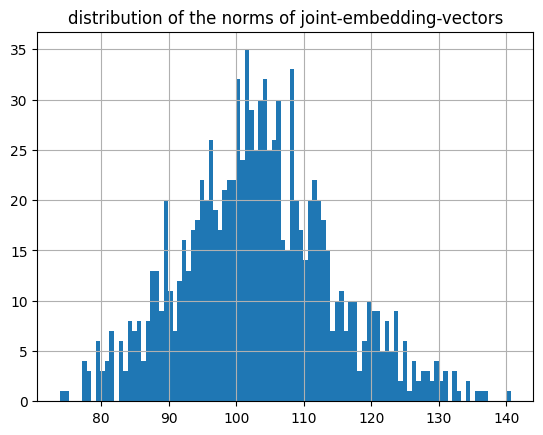

In [103]:
fts = features.iloc[:, :-1]

norms = fts.apply(np.linalg.norm, axis=1)
display(norms.describe())
norms.hist(bins=100)
plt.title('distribution of the norms of joint-embedding-vectors')
plt.show()


Vectors have a similar range of norm, It is not awful, but I will want to add a normalizing layer in my model in order to train the classifier.

# Retrieve train, val and test set product ids. 

In [61]:
main_dir = './Flipkart_products_images2'

for sub_dir in ['training', 'validation', 'testing']:
    var_name = sub_dir + '_product_ids'
    ids = []
    filenames = glob(os.path.join(main_dir, sub_dir) + '/*/*' )
    for filename in filenames:
        dir_, im_name = os.path.split(filename)
        ids.append(im_name.removesuffix('.jpg'))
    exec(var_name + ' = ids')
    

In [113]:
test_ds = features.loc[features.index.isin(testing_product_ids), :]
val_ds = features.loc[features.index.isin(validation_product_ids), :]
train_ds = features.loc[features.index.isin(training_product_ids), :]

In [105]:
test_ds.shape[0] + val_ds.shape[0] + train_ds.shape[0]

1050

In [106]:
train_ds.head()

,MobileNet_component_0,MobileNet_component_1,MobileNet_component_2,MobileNet_component_3,MobileNet_component_4,MobileNet_component_5,MobileNet_component_6,MobileNet_component_7,MobileNet_component_8,MobileNet_component_9,MobileNet_component_10,MobileNet_component_11,MobileNet_component_12,MobileNet_component_13,MobileNet_component_14,MobileNet_component_15,MobileNet_component_16,MobileNet_component_17,MobileNet_component_18,MobileNet_component_19,MobileNet_component_20,MobileNet_component_21,MobileNet_component_22,MobileNet_component_23,MobileNet_component_24,...,USE_component_488,USE_component_489,USE_component_490,USE_component_491,USE_component_492,USE_component_493,USE_component_494,USE_component_495,USE_component_496,USE_component_497,USE_component_498,USE_component_499,USE_component_500,USE_component_501,USE_component_502,USE_component_503,USE_component_504,USE_component_505,USE_component_506,USE_component_507,USE_component_508,USE_component_509,USE_component_510,USE_component_511,category
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,-6.907565,-3.640539,-5.543317,-5.131344,-6.398283,-4.566835,-5.429980,-0.298964,1.306576,2.261568,-1.276243,3.261032,3.687768,0.214665,2.995415,-0.204328,1.201007,3.182588,2.686737,2.740953,-1.678531,-3.656979,-0.349429,-0.870284,0.837836,...,-0.045738,0.006209,-0.029917,-0.003547,-0.034191,-0.053675,-0.010827,0.054492,0.053929,0.053175,-0.054431,0.044200,0.037451,0.054495,-0.048612,-0.054483,-0.054035,0.052842,0.034995,-0.053535,0.043256,0.048271,0.045517,-0.043024,home_furnishing
7b72c92c2f6c40268628ec5f14c6d590,-0.761519,-1.559877,-2.802782,-0.984374,-4.146284,-0.713606,-5.368144,-1.108315,-4.219600,-2.105635,-1.816751,-1.312072,-3.503740,-5.436931,-1.679037,-0.593286,-2.636722,0.158218,-0.484680,-1.999258,-0.089881,-3.888876,-3.198055,-8.115603,-5.037665,...,-0.023705,0.034793,0.025965,-0.042635,0.050545,-0.045741,-0.054322,0.057650,-0.033396,0.003192,-0.057343,0.008936,0.057554,0.057649,0.044541,-0.057512,-0.054354,-0.049278,-0.027530,-0.051291,-0.010424,0.025962,0.045426,0.019441,baby_care
64d5d4a258243731dc7bbb1eef49ad74,-1.625205,-2.635780,-4.608310,-8.318931,-5.668677,-2.030307,-2.953663,-2.825427,-3.927833,-0.758825,-3.745661,-4.492832,-2.584330,-4.844900,-1.879967,-1.856250,-3.436444,-0.198376,-2.633416,-2.999208,-5.303754,-4.542162,-5.122362,-6.364506,-1.364802,...,-0.024007,0.052840,0.050790,0.039559,0.052916,0.047236,-0.053779,0.053818,0.033410,-0.013591,-0.053805,0.017765,0.050401,0.053819,0.050409,-0.053819,-0.053407,0.004893,0.042462,-0.052525,0.046325,0.046371,-0.006871,-0.047135,baby_care
d4684dcdc759dd9cdf41504698d737d8,0.194298,-1.913051,1.124771,-0.390231,0.143823,1.128698,-1.978329,-1.428998,0.900681,-1.918233,-4.981120,-2.959623,-1.809269,-6.320896,-0.882317,1.418569,0.347472,-0.485900,-1.046891,-2.921104,-2.049241,-6.214575,-3.948079,-2.156913,-5.153284,...,-0.053811,-0.053562,0.052804,0.053730,-0.029780,-0.045985,-0.052121,0.053895,0.032886,0.013098,-0.050861,-0.047804,-0.023283,0.053902,-0.019811,-0.053902,0.023056,0.053237,-0.051261,-0.052120,0.053216,0.052879,-0.031654,-0.048502,home_furnishing
dd0e3470a7e6ed76fd69c2da27721041,-2.560608,-5.059023,1.766916,-6.141760,-3.326364,-3.760787,-4.482588,-2.571893,-4.771317,-2.663366,-4.871028,-5.920455,-7.537642,-5.059691,-6.072734,-4.454156,-5.446964,-2.763243,-1.222130,-4.051966,-4.140852,-0.827347,-0.162117,-4.059469,0.157181,...,0.031244,0.019195,0.053115,0.050232,-0.049800,0.032146,-0.048454,0.062169,0.031040,0.004400,-0.019667,0.061342,0.021846,0.064378,0.029491,-0.063897,-0.027754,-0.052457,0.054419,-0.057661,0.060279,-0.044965,0.047818,-0.057215,watches


In [107]:
# Prepare a layer for one hot encoding.
sorted_class_names = sorted(df.category.unique().tolist())
sorted_class_names

['baby_care',
 'beauty_and_personal_care',
 'computers',
 'home_decor_and_festive_needs',
 'home_furnishing',
 'kitchen_and_dining',
 'watches']

In [108]:
string_lookup_layer = tf.keras.layers.StringLookup(
    vocabulary=sorted_class_names,
    num_oov_indices=0,
    output_mode='one_hot'
)

string_lookup_layer(['baby_care', 'baby_care', 'kitchen_and_dining'])

/home/louberehc/miniconda3/lib/python3.10/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)>

In [111]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 700
BATCH_SIZE = 16


def make_tf_dataset(df, batch_size=16):
    features = df.iloc[:, :-1]
    labels = df.iloc[:, -1]
    
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = (
        ds
        .shuffle(BUFFER_SIZE)
        .map(lambda x, y: (x, string_lookup_layer(y)))
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return ds 

In [114]:
train_ds = make_tf_dataset(train_ds, BATCH_SIZE)

for row in train_ds.unbatch().take(3):
    print(row)



(<tf.Tensor: shape=(1512,), dtype=float32, numpy=
array([-3.5661039e+00, -3.1916270e+00, -6.9899449e+00, ...,
        8.2024257e-04, -2.0726491e-02, -5.6871317e-02], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(1512,), dtype=float32, numpy=
array([-5.9016080e+00, -7.5382107e-01, -4.8096194e+00, ...,
        5.3287391e-03, -5.6018315e-02, -1.4785423e-02], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(1512,), dtype=float32, numpy=
array([-5.1925540e+00, -2.1182084e+00, -3.6910717e+00, ...,
        3.1839618e-03, -5.4531071e-02, -5.2499123e-02], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)>)


2023-06-20 17:03:29.541233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [679,1512]
	 [[{{node Placeholder/_0}}]]
2023-06-20 17:03:29.541840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64
	 [[{{node Placeholder/_9}}]]


In [115]:
val_ds = make_tf_dataset(val_ds, BATCH_SIZE)
test_ds = make_tf_dataset(test_ds, BATCH_SIZE)

# Create a basic classifier model

In [116]:
BATCH_SIZE = 16

In [117]:
STEPS_PER_EPOCH = len(train_ds) // BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*5,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [124]:
n_classes = 7

normalizer = tf.keras.layers.Normalization(axis=-1)

def make_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(n_classes, activation='softmax'),
    ])

    return model


# Prepare directories for logs and model weights
logdir = './logs_joint'  
if not os.path.exists(logdir):
    os.mkdir(logdir)
    
modeldir = './models_joint'  
if not os.path.exists(logdir):
    os.mkdir(logdir)

# Configure callback functions.
def get_callbacks(name):
    return [

        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(modeldir, name),   
            monitor='val_loss',
            verbose=1,
            save_weights_only=True, 
            save_best_only=True,
            mode='min'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10
        ),
        tf.keras.callbacks.TensorBoard(os.path.join(logdir, name)),
        
    ]
    

def compile_and_fit(
    model,
    name,
    train_ds,
    val_ds,
    optimizer=None,
    max_epochs=50,
    BATCH_SIZE=16,
):
    if optimizer is None:
        optimizer = get_optimizer()
      
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'],)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=BATCH_SIZE,
        epochs=max_epochs,
        callbacks=get_callbacks(name),
        verbose=1
    )
    return history

In [125]:
model = make_model()

history = compile_and_fit(
    model,
    "model1",
    train_ds,
    val_ds,
)

Epoch 1/50


2023-06-20 17:08:35.911203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64
	 [[{{node Placeholder/_9}}]]
2023-06-20 17:08:35.911721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [679,1512]
	 [[{{node Placeholder/_0}}]]


35/43 [=======================>......] - ETA: 0s - loss: 1.8440 - accuracy: 0.6036

2023-06-20 17:08:36.980125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64
	 [[{{node Placeholder/_9}}]]
2023-06-20 17:08:36.980633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype resource
	 [[{{node Placeholder/_8}}]]



Epoch 1: val_loss improved from inf to 0.79101, saving model to ./models_joint/model1
43/43 [==============================] - 1s 14ms/step - loss: 1.8854 - accuracy: 0.6127 - val_loss: 0.7910 - val_accuracy: 0.8214
Epoch 2/50
36/43 [========================>.....] - ETA: 0s - loss: 0.7201 - accuracy: 0.7917
Epoch 2: val_loss improved from 0.79101 to 0.64417, saving model to ./models_joint/model1
43/43 [==============================] - 0s 8ms/step - loss: 0.6835 - accuracy: 0.7968 - val_loss: 0.6442 - val_accuracy: 0.8393
Epoch 3/50
36/43 [========================>.....] - ETA: 0s - loss: 0.4311 - accuracy: 0.8524
Epoch 3: val_loss did not improve from 0.64417
43/43 [==============================] - 0s 9ms/step - loss: 0.4145 - accuracy: 0.8571 - val_loss: 0.6506 - val_accuracy: 0.8393
Epoch 4/50
37/43 [========================>.....] - ETA: 0s - loss: 0.3565 - accuracy: 0.8936
Epoch 4: val_loss improved from 0.64417 to 0.62340, saving model to ./models_joint/model1
43/43 [=========

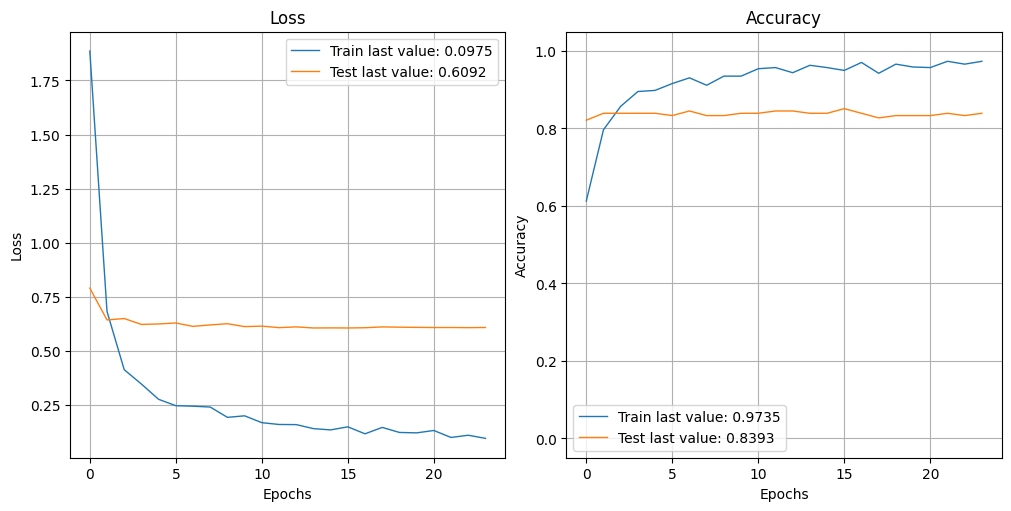

In [127]:
show_history(history)
plot_history(history)
plt.close()

# Second model with more dropout

In [130]:
def make_model2():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(n_classes, activation='softmax'),
    ])

    return model

In [131]:
model = make_model2()

history = compile_and_fit(
    model,
    "model2",
    train_ds,
    val_ds,
)

Epoch 1/50
36/43 [========================>.....] - ETA: 0s - loss: 2.2116 - accuracy: 0.5729
Epoch 1: val_loss improved from inf to 0.91009, saving model to ./models_joint/model2
43/43 [==============================] - 1s 11ms/step - loss: 2.0521 - accuracy: 0.5935 - val_loss: 0.9101 - val_accuracy: 0.8095
Epoch 2/50
37/43 [========================>.....] - ETA: 0s - loss: 0.9235 - accuracy: 0.7568
Epoch 2: val_loss improved from 0.91009 to 0.72231, saving model to ./models_joint/model2
43/43 [==============================] - 0s 8ms/step - loss: 0.9111 - accuracy: 0.7629 - val_loss: 0.7223 - val_accuracy: 0.8333
Epoch 3/50
42/43 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.7991
Epoch 3: val_loss improved from 0.72231 to 0.69217, saving model to ./models_joint/model2
43/43 [==============================] - 0s 9ms/step - loss: 0.6549 - accuracy: 0.8012 - val_loss: 0.6922 - val_accuracy: 0.8155
Epoch 4/50
36/43 [========================>.....] - ETA: 0s - lo

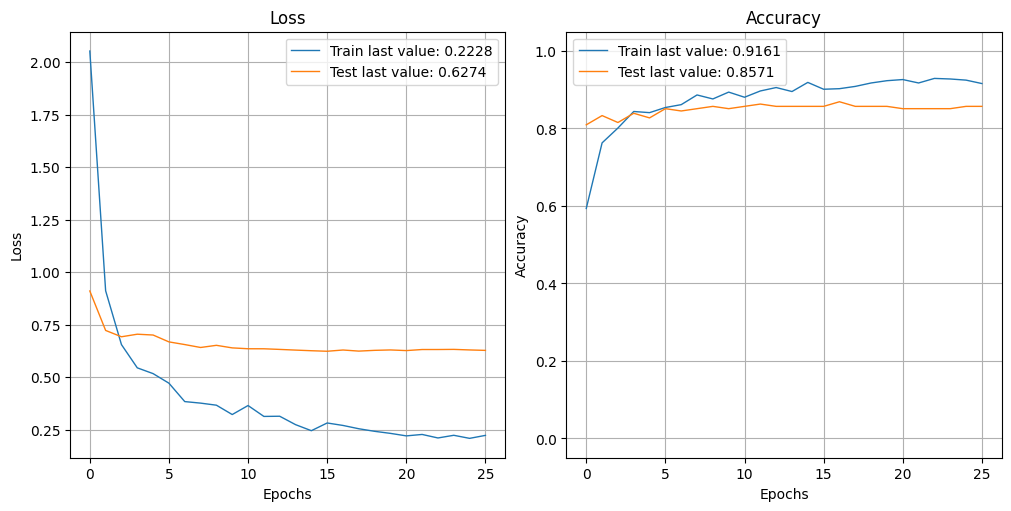

In [132]:
show_history(history)
plot_history(history)
plt.close()

# Third model with more dropout and regularization

In [136]:
def make_model3():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(
            256,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)
        ),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(
            n_classes,
            activation='softmax',
            kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)
        )
    ])

    return model

In [142]:
model = make_model3()

history = compile_and_fit(
    model,
    "model3",
    train_ds,
    val_ds,
    max_epochs=50
)

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 2.9247 - accuracy: 0.5773
Epoch 1: val_loss improved from inf to 1.52987, saving model to ./models_joint/model3
43/43 [==============================] - 1s 11ms/step - loss: 2.9247 - accuracy: 0.5773 - val_loss: 1.5299 - val_accuracy: 0.7917
Epoch 2/50
36/43 [========================>.....] - ETA: 0s - loss: 1.3914 - accuracy: 0.7847
Epoch 2: val_loss improved from 1.52987 to 1.30070, saving model to ./models_joint/model3
43/43 [==============================] - 0s 8ms/step - loss: 1.3953 - accuracy: 0.7850 - val_loss: 1.3007 - val_accuracy: 0.8095
Epoch 3/50
40/43 [==========================>...] - ETA: 0s - loss: 1.1966 - accuracy: 0.8203
Epoch 3: val_loss improved from 1.30070 to 1.27306, saving model to ./models_joint/model3
43/43 [==============================] - 0s 9ms/step - loss: 1.2072 - accuracy: 0.8159 - val_loss: 1.2731 - val_accuracy: 0.8214
Epoch 4/50
36/43 [========================>.....] - ETA: 0s - lo

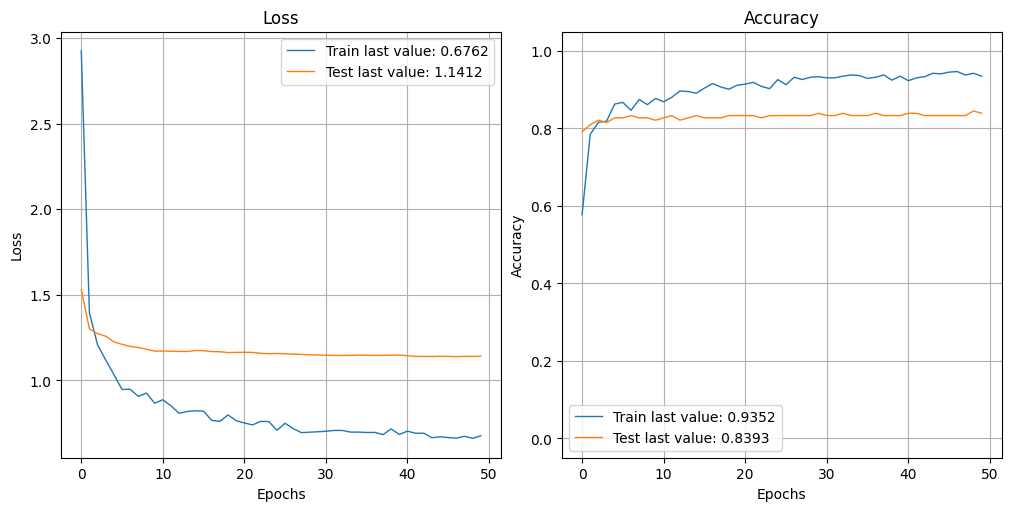

In [143]:
show_history(history)
plot_history(history)
plt.close()